In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans
import torch.nn as nn
from sklearn.metrics import silhouette_score

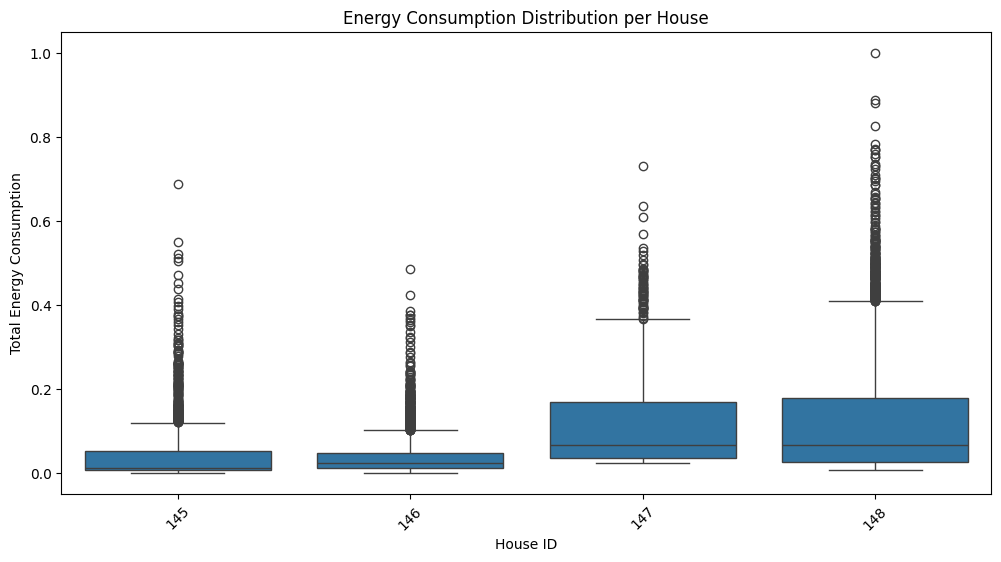


House Energy Statistics:
              mean       std       max       min
house_id                                        
145       0.040418  0.062407  0.687518  0.000000
146       0.040091  0.048220  0.486837  0.000183
147       0.112887  0.095077  0.732051  0.024933
148       0.135932  0.157956  1.000000  0.006544


In [2]:
# Load datasets (already loaded in previous step)
madalena_df = pd.read_csv("datasets/temp/madalena_sample.csv")
korean_df = pd.read_csv("datasets/temp/merged_korean_corrected.csv")
# Convert timestamp to datetime
madalena_df["timestamp"] = pd.to_datetime(madalena_df["timestamp"])
korean_df["timestamp"] = pd.to_datetime(korean_df["timestamp"])

madalena_df.drop(columns=["Unnamed: 0"], inplace=True)

madalena_df["hour"] = madalena_df["timestamp"].dt.hour
madalena_df["day_of_week"] = madalena_df["timestamp"].dt.dayofweek
madalena_df.to_csv("datasets/temp/madalena_sample2.csv", index=False)
feature_cols = ["total_energy", "T_out [°C]", "hour", "day_of_week"]  # Input features
comfort_cols = ["T_in[°C]", "RH [%]", "CO2[ppm]", "PM2_5[ug/m3]"]  # Target comfort metrics

scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

madalena_df[feature_cols] = scaler_X.fit_transform(madalena_df[feature_cols])
madalena_df[comfort_cols] = scaler_Y.fit_transform(madalena_df[comfort_cols])

sequence_length = 60

house_energy_stats = madalena_df.groupby("house_id")["total_energy"].agg(["mean", "std", "max", "min"])

plt.figure(figsize=(12, 6))
sns.boxplot(x="house_id", y="total_energy", data=madalena_df)
plt.xticks(rotation=45)
plt.title("Energy Consumption Distribution per House")
plt.xlabel("House ID")
plt.ylabel("Total Energy Consumption")
plt.show()

def print_summary_stats(df):
    print("\nHouse Energy Statistics:")
    print(df.to_string())

print_summary_stats(house_energy_stats)

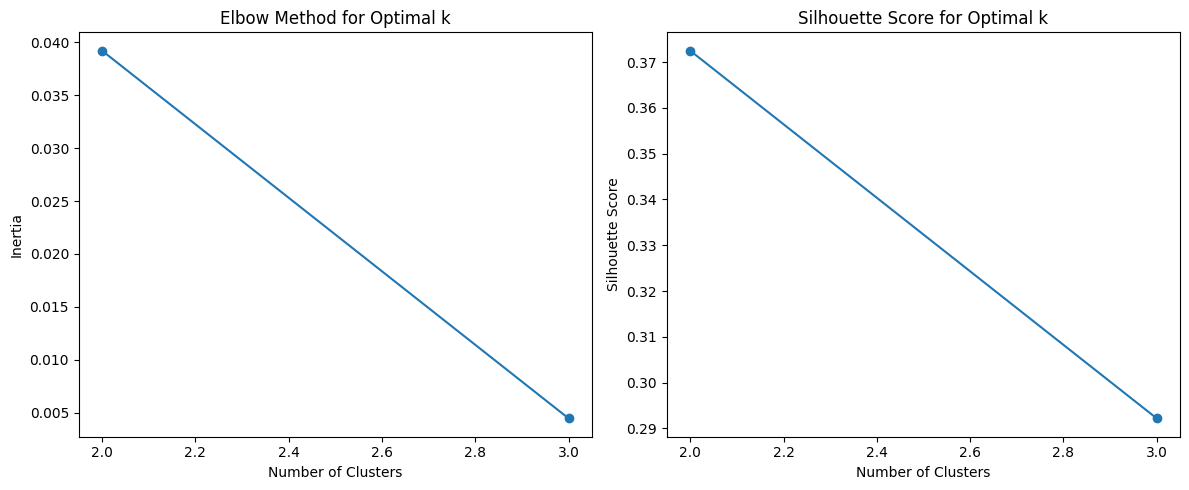

In [29]:
X_cluster = house_energy_stats.values
inertia = []
silhouette_scores = []

# we only have 4 houses
k_range = range(2, 4)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=4, n_init=10)
    labels = kmeans.fit_predict(X_cluster)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster, labels))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')

plt.tight_layout()
plt.show()


Manual Cluster Assignments:
      house_id  cluster
0          145        0
2749       146        0
5698       147        1
8647       148        1
timestamp        datetime64[ns]
total_energy            float64
CO2[ppm]                float64
PM4[ug/m3]              float64
Lighting[lux]           float64
T_in[°C]                float64
RH [%]                  float64
PM10[ug/m3]             float64
PM2_5[ug/m3]            float64
PM1[ug/m3]              float64
PM0_5[ug/m3]            float64
T_out [°C]              float64
house_id                  int64
hour                    float64
day_of_week             float64
cluster                   int64
dtype: object


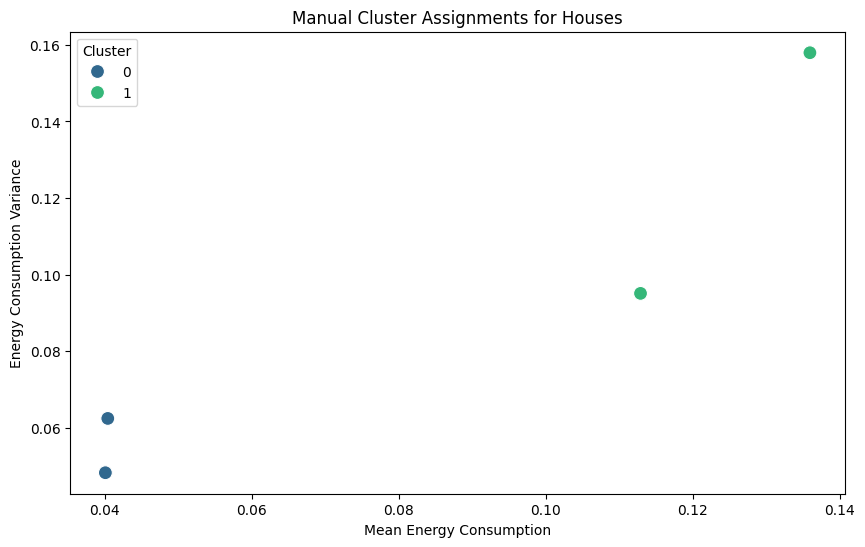


House Energy Statistics with Manual Clusters:
              mean       std       max       min
house_id                                        
145       0.040418  0.062407  0.687518  0.000000
146       0.040091  0.048220  0.486837  0.000183
147       0.112887  0.095077  0.732051  0.024933
148       0.135932  0.157956  1.000000  0.006544


In [ ]:
house_cluster_mapping = {145: 0, 146: 0, 147: 1, 148: 1}
madalena_df["cluster"] = madalena_df["house_id"].map(house_cluster_mapping)
print("Manual Cluster Assignments:")
print(madalena_df[["house_id", "cluster"]].drop_duplicates())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=house_energy_stats["mean"], y=house_energy_stats["std"], hue=[house_cluster_mapping[h] for h in house_energy_stats.index], palette='viridis', s=100)
plt.xlabel("Mean Energy Consumption")
plt.ylabel("Energy Consumption Variance")
plt.title("Manual Cluster Assignments for Houses")
plt.legend(title="Cluster")
plt.show()

# Print summary statistics
def print_summary_stats(df):
    print("\nHouse Energy Statistics with Manual Clusters:")
    print(df.to_string())

print_summary_stats(house_energy_stats)

Epoch 1/16 - Train Loss: 0.0204 - Val Loss: 0.0152 - MAE: 0.0976 - R²: -2.3342
Epoch 2/16 - Train Loss: 0.0134 - Val Loss: 0.0221 - MAE: 0.1214 - R²: -10.8228
Epoch 3/16 - Train Loss: 0.0124 - Val Loss: 0.0261 - MAE: 0.1277 - R²: -18.0925
Epoch 4/16 - Train Loss: 0.0117 - Val Loss: 0.0223 - MAE: 0.1226 - R²: -12.1343
Epoch 5/16 - Train Loss: 0.0112 - Val Loss: 0.0184 - MAE: 0.1083 - R²: -8.9519
Epoch 6/16 - Train Loss: 0.0105 - Val Loss: 0.0229 - MAE: 0.1255 - R²: -10.5050
Epoch 7/16 - Train Loss: 0.0098 - Val Loss: 0.0198 - MAE: 0.1124 - R²: -9.5917
Epoch 8/16 - Train Loss: 0.0093 - Val Loss: 0.0194 - MAE: 0.1108 - R²: -8.3342
Epoch 9/16 - Train Loss: 0.0071 - Val Loss: 0.0227 - MAE: 0.1189 - R²: -11.9847
Epoch 10/16 - Train Loss: 0.0065 - Val Loss: 0.0165 - MAE: 0.0977 - R²: -7.2951
Epoch 11/16 - Train Loss: 0.0063 - Val Loss: 0.0235 - MAE: 0.1226 - R²: -12.8987
Epoch 12/16 - Train Loss: 0.0058 - Val Loss: 0.0169 - MAE: 0.0992 - R²: -7.5475
Epoch 13/16 - Train Loss: 0.0054 - Val Loss

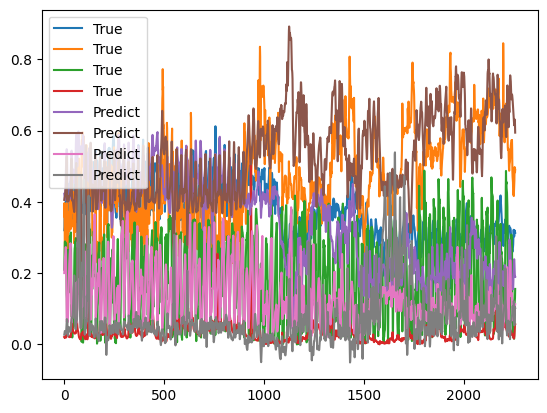

Training completed for all clusters.


In [ ]:
# import torch.optim as optim
# from sklearn.metrics import mean_absolute_error, r2_score

# class EnergyDataset(Dataset):
#     def __init__(self, data, targets, sequence_length):
#         self.data = data
#         self.targets = targets
#         self.sequence_length = sequence_length

#     def __len__(self):
#         return len(self.data) - self.sequence_length

#     def __getitem__(self, idx):
#         x_seq = self.data[idx:idx + self.sequence_length]
#         y_target = self.targets[idx + self.sequence_length]
#         return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_target, dtype=torch.float32)

# # Train separate LSTMs for each cluster
# lstm_models = {}
# optimizers = {}
# loss_function = nn.MSELoss()

# # Extract data for all houses
# data_X = madalena_df[feature_cols].values
# data_Y = madalena_df[comfort_cols].values

# # Split into training and validation sets
# train_size = int(0.8 * len(data_X))
# X_train, X_val = data_X[:train_size], data_X[train_size:]
# Y_train, Y_val = data_Y[:train_size], data_Y[train_size:]

# # Create PyTorch Datasets and DataLoaders
# train_dataset = EnergyDataset(X_train, Y_train, sequence_length)
# val_dataset = EnergyDataset(X_val, Y_val, sequence_length)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# # Define LSTM Model
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, num_layers=3):
#         super(LSTMModel, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)
    
#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)
#         return self.fc(lstm_out[:, -1, :])

# # Initialize model
# model = LSTMModel(input_size=len(feature_cols), hidden_size=128, output_size=len(comfort_cols))
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss_function = nn.MSELoss()

# # Training loop
# num_epochs = 16
# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0
#     for X_batch, Y_batch in train_loader:
#         optimizer.zero_grad()
#         output = model(X_batch)
#         loss = loss_function(output, Y_batch)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
    
#     # Validation
#     model.eval()
#     val_loss = 0.0
#     Y_true, Y_pred = [], []
#     with torch.no_grad():
#         for X_batch, Y_batch in val_loader:
#             output = model(X_batch)
#             loss = loss_function(output, Y_batch)
#             val_loss += loss.item()
#             Y_true.append(Y_batch.numpy())
#             Y_pred.append(output.numpy())
    
#     # Flatten arrays for evaluation
#     Y_true = np.vstack(Y_true)
#     Y_pred = np.vstack(Y_pred)
    
#     # Compute additional evaluation metrics
#     mae = mean_absolute_error(Y_true, Y_pred)
#     r2 = r2_score(Y_true, Y_pred)
    
#     print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss/len(train_loader):.4f} - Val Loss: {val_loss/len(val_loader):.4f} - MAE: {mae:.4f} - R²: {r2:.4f}")
    
#     if epoch+1 == 16:
#         plt.plot(Y_true, label='True')
#         plt.plot(Y_pred,  label='Predict')
#         plt.legend()
#         plt.show()

# print("Training completed for all clusters.")

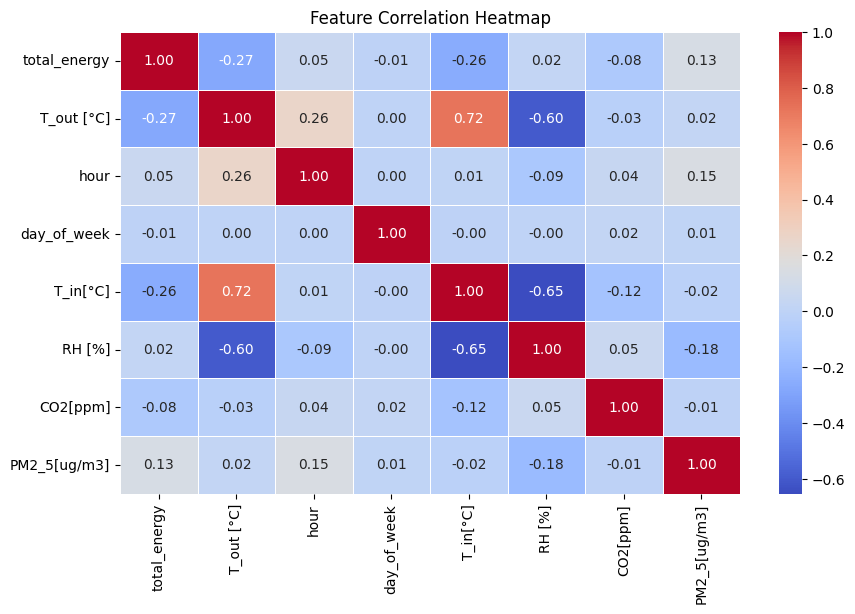

In [ ]:
plt.figure(figsize=(10, 6))
corr_matrix = madalena_df[feature_cols + comfort_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()                                               

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

file_path = "datasets/temp/madalena_sample2.csv"  
df = pd.read_csv(file_path)

df['timestamp'] = pd.to_datetime(df['timestamp'])

df['energy_rolling_mean_3h'] = df.groupby('house_id')['total_energy'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['rolling_energy_variance_3h'] = df.groupby('house_id')['total_energy'].transform(lambda x: x.rolling(window=3, min_periods=1).var())
df['CO2_hourly_change'] = df.groupby('house_id')['CO2[ppm]'].diff().fillna(0)
df['HVAC_activity'] = abs(df['T_in[°C]'].diff().fillna(0))
df['sin_hour'] = np.sin(df['hour'] * np.pi / 12)
df['cos_hour'] = np.cos(df['hour'] * np.pi / 12)

df.fillna(0, inplace=True)

X = df[['total_energy', 'energy_rolling_mean_3h', 'rolling_energy_variance_3h',
        'T_out [°C]', 'hour', 'day_of_week', 'HVAC_activity', 'CO2_hourly_change',
        'sin_hour', 'cos_hour', 'house_id']]
Y = df[['T_in[°C]', 'RH [%]', 'CO2[ppm]', 'PM4[ug/m3]', 'PM10[ug/m3]', 'PM2_5[ug/m3]', 'PM1[ug/m3]', 'PM0_5[ug/m3]', 'Lighting[lux]']]

X = X.values
Y = Y.values

sequence_length = 3 
X_seq, Y_seq = [], []
for i in range(len(X) - sequence_length):
    X_seq.append(X[i:i+sequence_length])
    Y_seq.append(Y[i+sequence_length])
X_seq, Y_seq = np.array(X_seq), np.array(Y_seq)

X_train, X_test, Y_train, Y_test = train_test_split(X_seq, Y_seq, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class ComfortLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(ComfortLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  
        return out

model = ComfortLSTM(input_dim=X_train.shape[2], hidden_dim=64, output_dim=Y_train.shape[1], num_layers=2)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

train_model(model, train_loader, criterion, optimizer, epochs=50)

def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            Y_pred = model(X_batch)
            predictions.append(Y_pred.numpy())
            actuals.append(Y_batch.numpy())
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    mae = np.mean(np.abs(predictions - actuals), axis=0)
    for i, metric in enumerate(Y[0]):
        print(f"MAE for {metric}: {mae[i]:.2f}")

evaluate_model(model, test_loader)


Epoch 1/50, Loss: 61375.6631
Epoch 2/50, Loss: 40546.6874
Epoch 3/50, Loss: 29091.4862
Epoch 4/50, Loss: 22986.2916
Epoch 5/50, Loss: 20106.0723
Epoch 6/50, Loss: 18965.5885
Epoch 7/50, Loss: 19127.1184
Epoch 8/50, Loss: 17129.8685
Epoch 9/50, Loss: 16224.2194
Epoch 10/50, Loss: 15580.3136
Epoch 11/50, Loss: 14975.3287
Epoch 12/50, Loss: 14272.4896
Epoch 13/50, Loss: 12802.8307
Epoch 14/50, Loss: 11104.7015
Epoch 15/50, Loss: 9679.2157
Epoch 16/50, Loss: 8798.3810
Epoch 17/50, Loss: 8165.0060
Epoch 18/50, Loss: 7688.6361
Epoch 19/50, Loss: 7241.1439
Epoch 20/50, Loss: 6948.9278
Epoch 21/50, Loss: 6629.0670
Epoch 22/50, Loss: 6467.1317
Epoch 23/50, Loss: 6304.0609
Epoch 24/50, Loss: 5980.9598
Epoch 25/50, Loss: 5954.2018
Epoch 26/50, Loss: 5677.3201
Epoch 27/50, Loss: 5467.4667
Epoch 28/50, Loss: 5546.4044
Epoch 29/50, Loss: 5269.1391
Epoch 30/50, Loss: 4953.0877
Epoch 31/50, Loss: 4832.6338
Epoch 32/50, Loss: 4763.9009
Epoch 33/50, Loss: 4623.8128
Epoch 34/50, Loss: 4383.1941
Epoch 35/

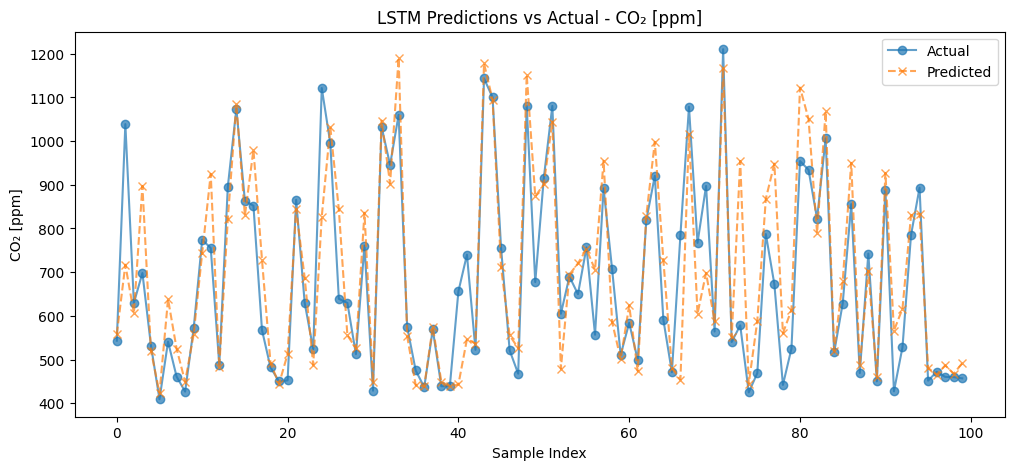

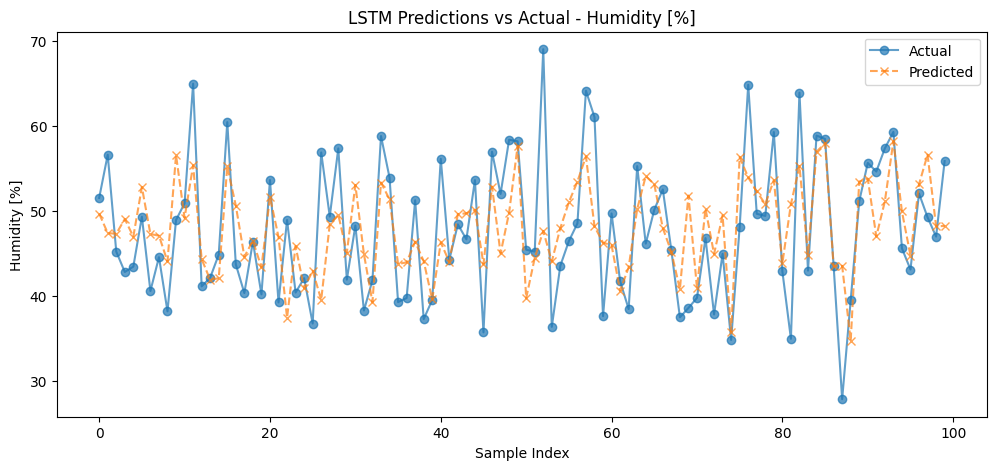

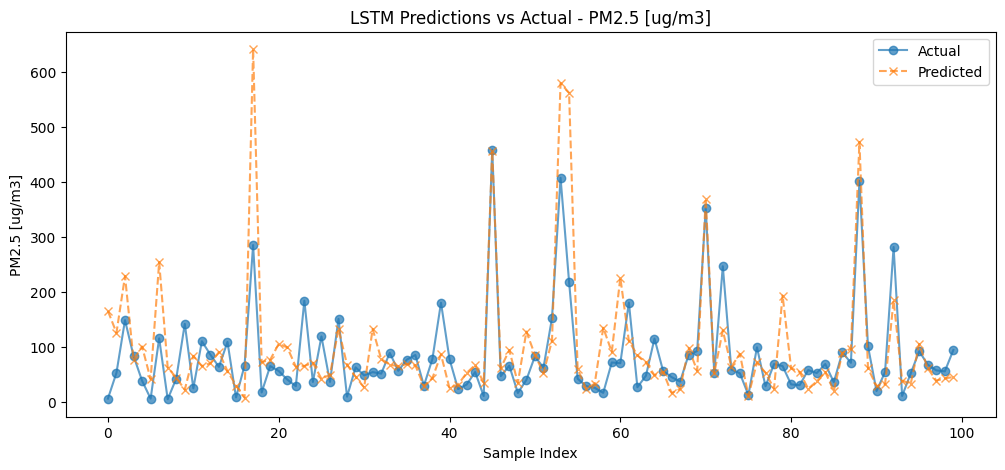

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize LSTM predictions vs actual values for a given metric
def plot_lstm_predictions(model, test_loader, metric_index, metric_name):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            Y_pred = model(X_batch)
            predictions.append(Y_pred.numpy())
            actuals.append(Y_batch.numpy())

    # Convert lists to numpy arrays
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)

    # Select a sample of 100 predictions for visualization
    num_samples = min(100, len(predictions))
    plt.figure(figsize=(12, 5))
    plt.plot(actuals[:num_samples, metric_index], label="Actual", linestyle="-", marker="o", alpha=0.7)
    plt.plot(predictions[:num_samples, metric_index], label="Predicted", linestyle="--", marker="x", alpha=0.7)
    plt.xlabel("Sample Index")
    plt.ylabel(metric_name)
    plt.title(f"LSTM Predictions vs Actual - {metric_name}")
    plt.legend()
    plt.show()

# Example usage: Visualizing CO₂ predictions (assuming it's the 3rd column in Y)
plot_lstm_predictions(model, test_loader, metric_index=2, metric_name="CO₂ [ppm]")
plot_lstm_predictions(model, test_loader, metric_index=1, metric_name="Humidity [%]")
plot_lstm_predictions(model, test_loader, metric_index=5, metric_name="PM2.5 [ug/m3]")

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

file_path = "datasets/temp/madalena_sample2.csv"  
df = pd.read_csv(file_path)

df['timestamp'] = pd.to_datetime(df['timestamp'])

# df['energy_rolling_mean_3h'] = df.groupby('house_id')['total_energy'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
# df['rolling_energy_variance_3h'] = df.groupby('house_id')['total_energy'].transform(lambda x: x.rolling(window=3, min_periods=1).var())
# df['CO2_hourly_change'] = df.groupby('house_id')['CO2[ppm]'].diff().fillna(0)
# df['CO2_rolling_mean_3h'] = df.groupby('house_id')['CO2[ppm]'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
# df['HVAC_activity'] = abs(df['T_in[°C]'].diff().fillna(0))
# df['sin_hour'] = np.sin(df['hour'] * np.pi / 12)
# df['cos_hour'] = np.cos(df['hour'] * np.pi / 12)
# df['month'] = df['timestamp'].dt.month
df['day_of_week'] = df['timestamp'].dt.dayofweek

df['CO2_lag_1h'] = df.groupby('house_id')['CO2[ppm]'].shift(1).fillna(method='bfill')
df['total_energy_lag_1h'] = df.groupby('house_id')['total_energy'].shift(1).fillna(method='bfill')
# df['HVAC_activity_lag_1h'] = df.groupby('house_id')['HVAC_activity'].shift(1).fillna(method='bfill')

df.fillna(0, inplace=True)

X = df[['total_energy', 
        'hour', 'day_of_week',
        'house_id', 'total_energy_lag_1h']]
Y = df[['T_in[°C]', 'RH [%]', 'CO2[ppm]', 'PM2_5[ug/m3]', 'Lighting[lux]']]
metric_names = Y.columns.tolist() 

X = X.values
Y = Y.values

scaler = StandardScaler()
X = scaler.fit_transform(X)

target_scalers = {}
for i in range(Y.shape[1]):
    scaler = MinMaxScaler()
    Y[:, i] = scaler.fit_transform(Y[:, i].reshape(-1, 1)).flatten()
    target_scalers[i] = scaler 

sequence_length = 4
X_seq, Y_seq = [], []
for i in range(len(X) - sequence_length):
    X_seq.append(X[i:i+sequence_length])
    Y_seq.append(Y[i+sequence_length])
X_seq, Y_seq = np.array(X_seq), np.array(Y_seq)

X_train, X_test, Y_train, Y_test = train_test_split(X_seq, Y_seq, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class ComfortLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(ComfortLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Take the last LSTM output
        return out

model = ComfortLSTM(input_dim=X_train.shape[2], hidden_dim=32, output_dim=Y_train.shape[1], num_layers=2)

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

def train_model(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            Y_pred = model(X_batch)
            loss = criterion(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")                              

train_model(model, train_loader, criterion, optimizer, epochs=20)

def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            Y_pred = model(X_batch)
            predictions.append(Y_pred.numpy())
            actuals.append(Y_batch.numpy())
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    
    for i in range(Y.shape[1]):
        predictions[:, i] = target_scalers[i].inverse_transform(predictions[:, i].reshape(-1, 1)).flatten()
        actuals[:, i] = target_scalers[i].inverse_transform(actuals[:, i].reshape(-1, 1)).flatten()
    
    mae = np.mean(np.abs(predictions - actuals), axis=0)
    for i, metric in enumerate(metric_names):
        print(f"MAE for {metric}: {mae[i]:.2f}")

evaluate_model(model, test_loader)



C:\Users\Kelsier\AppData\Local\Temp\ipykernel_6320\736837952.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['CO2_lag_1h'] = df.groupby('house_id')['CO2[ppm]'].shift(1).fillna(method='bfill')
C:\Users\Kelsier\AppData\Local\Temp\ipykernel_6320\736837952.py:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['total_energy_lag_1h'] = df.groupby('house_id')['total_energy'].shift(1).fillna(method='bfill')


Epoch 1/20, Loss: 0.0086
Epoch 2/20, Loss: 0.0065
Epoch 3/20, Loss: 0.0062
Epoch 4/20, Loss: 0.0059
Epoch 5/20, Loss: 0.0059
Epoch 6/20, Loss: 0.0057
Epoch 7/20, Loss: 0.0056
Epoch 8/20, Loss: 0.0055
Epoch 9/20, Loss: 0.0054
Epoch 10/20, Loss: 0.0054
Epoch 11/20, Loss: 0.0053
Epoch 12/20, Loss: 0.0052
Epoch 13/20, Loss: 0.0051
Epoch 14/20, Loss: 0.0051
Epoch 15/20, Loss: 0.0050
Epoch 16/20, Loss: 0.0050
Epoch 17/20, Loss: 0.0050
Epoch 18/20, Loss: 0.0050
Epoch 19/20, Loss: 0.0048
Epoch 20/20, Loss: 0.0048
MAE for T_in[°C]: 1.78
MAE for RH [%]: 5.07
MAE for CO2[ppm]: 108.90
MAE for PM2_5[ug/m3]: 53.70
MAE for Lighting[lux]: 16.14


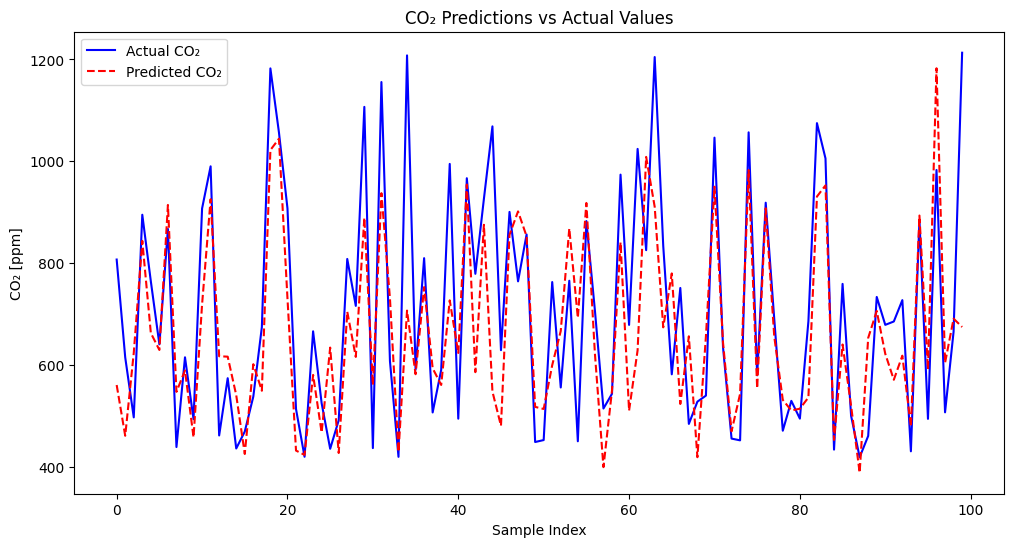

In [33]:
import matplotlib.pyplot as plt

def plot_co2_predictions(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            Y_pred = model(X_batch)
            predictions.append(Y_pred.numpy())
            actuals.append(Y_batch.numpy())
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)
    
    # Inverse transform CO₂ to original ppm values
    predictions[:, 2] = target_scalers[2].inverse_transform(predictions[:, 2].reshape(-1, 1)).flatten()
    actuals[:, 2] = target_scalers[2].inverse_transform(actuals[:, 2].reshape(-1, 1)).flatten()
    
    # Plot CO₂ predictions vs actual values
    plt.figure(figsize=(12, 6))
    plt.plot(actuals[:100, 2], label='Actual CO₂', color='blue')
    plt.plot(predictions[:100, 2], label='Predicted CO₂', color='red', linestyle='dashed')
    plt.xlabel("Sample Index")
    plt.ylabel("CO₂ [ppm]")
    plt.title("CO₂ Predictions vs Actual Values")
    plt.legend()
    plt.show()

# Evaluate and plot
plot_co2_predictions(model, test_loader)

In [32]:
# torch.save(model.state_dict(), "comfort_lstm_model.pth")
df.tail(100)

,timestamp,total_energy,CO2[ppm],PM4[ug/m3],Lighting[lux],T_in[°C],RH [%],PM10[ug/m3],PM2_5[ug/m3],PM1[ug/m3],PM0_5[ug/m3],T_out [°C],house_id,hour,day_of_week,CO2_lag_1h,total_energy_lag_1h
11495,2024-10-27 18:00:00,717.65,725.76,66.68,6.12,24.89,58.65,66.69,66.66,66.47,57.95,19.0,148,18,6,704.20,453.67
11496,2024-10-27 19:00:00,1556.92,844.17,93.01,5.32,25.04,59.42,93.03,92.99,92.73,80.83,18.7,148,19,6,725.76,717.65
11497,2024-10-27 20:00:00,242.40,766.54,123.13,1.42,25.02,59.46,123.16,123.10,122.75,107.01,18.5,148,20,6,844.17,1556.92
11498,2024-10-27 21:00:00,950.87,676.44,125.93,0.16,25.00,58.64,125.96,125.90,125.55,109.44,17.0,148,21,6,766.54,242.40
11499,2024-10-27 22:00:00,221.03,827.49,112.27,4.12,25.09,58.87,112.29,112.24,111.92,97.57,16.8,148,22,6,676.44,950.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11590,2024-10-31 17:00:00,1214.65,528.84,31.88,10.86,24.47,47.80,31.88,31.87,31.78,27.70,19.0,148,17,3,433.47,177.33
11591,2024-10-31 18:00:00,300.18,633.79,41.99,0.00,24.66,49.55,42.00,41.98,41.86,36.49,16.0,148,18,3,528.84,1214.65
11592,2024-10-31 19:00:00,456.90,656.30,57.03,0.00,24.62,49.11,57.04,57.01,56.85,49.56,14.6,148,19,3,633.79,300.18
11593,2024-10-31 20:00:00,387.93,666.76,73.79,0.00,24.56,48.88,73.81,73.77,73.56,64.13,13.5,148,20,3,656.30,456.90
